## Importando Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Latex


## Declarando a Classe de Teste

In [2]:
class Estimator:

    _w = None
    _k = None
    _a = 150
    _gainSpace = None
    _limitRatio = 0.25
    # Lista de valores para b de 0 -> 1500mm
    # 150 Samples gerados incluindo o ultimo valor "1500"mm
    # a -> 150 mm

    b_values = None
    c_values = None

    def __init__(self,width:float,kFactor:float,steps:int) -> None:

        self._w = width
        self._k = kFactor
        self.b_values = np.linspace(0,width,steps,True)
        self._gainSpace = np.linspace(0,1,steps,True)
        self.c_values = [np.sqrt(np.power(b_val,2) + np.power(150,2)) for b_val in self.b_values]


    @property
    def directDistanceSamples(self):
        return self.c_values

    @property
    def gainSpace(self):
        return self._gainSpace

    @property
    def verticalSamples(self):
        return self.b_values

    @property
    def boxWidthValue(self):
        return self._w

    @property
    def horizontalSample(self):
        return self._a


    def Expression(self,directDistance,vDistance,boxWidth,hDistance):

        # Apenas retorna a distância direta para n retornar erros
        if vDistance == 0 and hDistance==0: return self.RateSingleAxisDistance(directDistance)

        if vDistance == 0 and hDistance != 0:
            return self.RateSingleAxisDistance(hDistance)

        if hDistance == 0 and vDistance != 0:
            return self.RateSingleAxisDistance(directDistance)

        vThreshold = vDistance/hDistance
        hThreshold = hDistance < (0.1 * vDistance)

        # Se o valor da distância horizontal for muito menor ao valor vertical vDist >> hDist
        # O ponto de conexão está próx a lateral da caixa
        # Considera-se somente o valor da distância direta = distancia vertical adicionada de uma fração do seu valor moderada pela variavel "limiting ratio"
        if hThreshold : return self.RateSingleAxisDistance(vDistance)

        # Se o valor da distância vertical for muito menor ao valor horizontal vDist << hDistance
        # O ponto de conexão está próx a altura "y" do chicote
        # Considera-se somente o valor da distância direta adicionada de uma fração do seu valor moderada pela variavel "limiting ratio"
        if vThreshold < .1: return directDistance + (self._limitRatio * directDistance)

        denominator = (boxWidth - ( 2 * hDistance ))
        raw_decreasing_factor = (vDistance / denominator)
        flattened_factor = np.exp(-raw_decreasing_factor)
        result = (directDistance * (1 + self.CalibrateWeigths(flattened_factor,self._limitRatio)))
        return result

    def ExpressionTest(self,directDistance,vDistance,boxWidth,hDistance,gain):
        return self.Expression(directDistance,vDistance,boxWidth,hDistance)*gain

    def RateSingleAxisDistance(self,distance):
        return distance + (self._limitRatio * distance)

    def CalibrateWeigths(self,currentFactor,limit):
        #Calcula a diff abosulta entre o valor atual e o limite especificado
        diff = np.absolute(limit - currentFactor)

        if currentFactor < limit:
            return currentFactor + diff
        else:
            return currentFactor - diff





## Testes

In [3]:

step = 150
expTest = Estimator(1300, 1, step)
rng = range(0,len(expTest.directDistanceSamples))
markers = [25,50,75,100,149]



## Bases de Cálculo e Dados Gráficos

### Distância Estimada - K = 1

In [4]:
estimated_dist_no_gain = [expTest.Expression(expTest.directDistanceSamples[idx],expTest.verticalSamples[idx],expTest.boxWidthValue,expTest.horizontalSample) for idx in rng]

###  Sobra Absoluta - D/C

In [5]:
estimated_dist_ratio = [estimated_dist_no_gain[idx]/expTest.directDistanceSamples[idx] for idx in rng]


### Soma das Alturas Verticais e Horizontais - A + B

In [6]:
ab_ratio = [(bVal + expTest.horizontalSample) for bVal in expTest.verticalSamples]

### Comportamento da Distância Estimada em Função de K

In [7]:
last_y_k_Values =[expTest.ExpressionTest(expTest.directDistanceSamples[step-1],expTest.verticalSamples[step-1],expTest.boxWidthValue,expTest.horizontalSample,expTest.gainSpace[idx]) for idx in rng]

# Gráficos

## Sobra de Comprimento - Estimativa

<AxesSubplot:xlabel='Estimado', ylabel='D/C'>

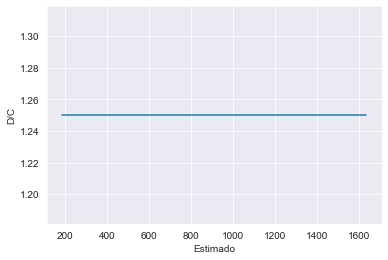

In [8]:
estimated_cols = ['Estimado','D/C']
estimated_frame = pd.DataFrame(np.array([estimated_dist_no_gain,estimated_dist_ratio]))
transposed_estimate = estimated_frame.T
transposed_estimate.columns = estimated_cols
sns.lineplot(
    x=r"Estimado",
    y=r"D/C",
    data=transposed_estimate
)

## Relação Entre 'A+B'

<AxesSubplot:xlabel='$D_{dir}$', ylabel='$D_{dir}(D_{vert},D_{hor})$'>

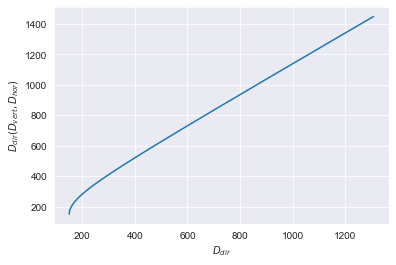

In [9]:
# Relação entre C e os valores de A e B

ab_cols = [r'$D_{dir}$',r'$D_{dir}(D_{vert},D_{hor})$']

ab_frame = pd.DataFrame(np.array([
    expTest.directDistanceSamples,
    ab_ratio
]))

ab_transposed = ab_frame.T
ab_transposed.columns = ab_cols

sns.lineplot(
    x=ab_transposed.columns[0],
    y=ab_transposed.columns[1],
    data = ab_transposed
)


#plt.plot(expTest.directDistanceSamples,ab_ratio,'-gD',markevery=markers)
#plt.ylabel("C [mm]")
#plt.title("C(A,B) [mm]")
#plt.xlabel(r'$A + B$')

### Preview

In [10]:
ab_transposed

,$D_{dir}$,"$D_{dir}(D_{vert},D_{hor})$"
0,150.000000,150.000000
1,150.253528,158.724832
2,151.011558,167.449664
3,152.266557,176.174497
4,154.006374,184.899329
...,...,...
145,1273.962208,1415.100671
146,1282.626763,1423.825503
147,1291.292129,1432.550336
148,1299.958291,1441.275168


## Distância Estimada - D [mm]

### Fórmula

In [11]:
%%latex
\begin{aligned}
    \begin{equation}
        \huge \mathbf{D} = D_{dir} \cdot \Bigl[ 1 + e^{- \bigl( \frac{D_{vert}}{B_{width} - 2\cdot D_{hor}} \bigr) } \Bigr] \cdot K
    \end{equation}
\end{aligned}

<IPython.core.display.Latex object>

##### Onde

- $ \large D$ = Distância Estimada [mm]
- $ \large D_{dir}$ = Distância direta entre $P_{1}$ e $P_{2}$
- $ \large D_{vert}$ = Distância vertical entre $P_{1}$ e $P_{2}$
- $ \large D_{hor}$ = Distância horizontal entre $P_{1}$ e $P_{2}$
- $ \large K$ = Ganho Limite
- $ \large B_{width}$ = Largura atual da caixa

<AxesSubplot:xlabel='$D_{dir} [mm]$', ylabel='D[mm]'>

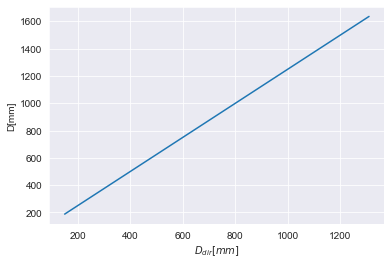

In [12]:

d_estimated_cols = [r"$D_{dir} [mm]$",r'D[mm]']

d_estimated_frame = pd.DataFrame(np.array([
    expTest.directDistanceSamples,
    estimated_dist_no_gain
])).T

d_estimated_frame.columns = d_estimated_cols

sns.lineplot(
    x=d_estimated_frame.columns[0],
    y=d_estimated_frame.columns[1],
    data=d_estimated_frame
)


### Preview

In [13]:
d_estimated_frame

,$D_{dir} [mm]$,D[mm]
0,150.000000,187.500000
1,150.253528,187.816910
2,151.011558,188.764448
3,152.266557,190.333196
4,154.006374,192.507967
...,...,...
145,1273.962208,1592.452760
146,1282.626763,1603.283454
147,1291.292129,1614.115162
148,1299.958291,1624.947864


## Comprimento Estimado em Função do Ganho limite (K)

<AxesSubplot:xlabel='K', ylabel='D [mm]'>

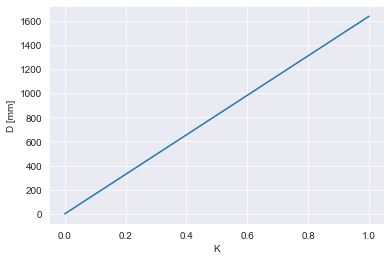

In [14]:
#plt.plot(expTest.gainSpace,last_y_k_Values,'-gD',markevery=markers)
#plt.ylabel("D [mm]")
#plt.title(rf"$D(150)(K)$")
#plt.xlabel('K')

estimated_k_related_framecols = [rf"K",'D [mm]']
estimated_k_related_frame = pd.DataFrame(np.array([
    expTest.gainSpace,
    last_y_k_Values
])).T

estimated_k_related_frame.columns = estimated_k_related_framecols

sns.lineplot(
    x=estimated_k_related_frame.columns[0],
    y=estimated_k_related_frame.columns[1],
    data=estimated_k_related_frame
)


### Preview

In [15]:
estimated_k_related_frame

,K,D [mm]
0,0.000000,0.000000
1,0.006711,10.978400
2,0.013423,21.956799
3,0.020134,32.935199
4,0.026846,43.913598
...,...,...
145,0.973154,1591.867943
146,0.979866,1602.846342
147,0.986577,1613.824742
148,0.993289,1624.803141


## Dataframe dos Resultados

In [16]:
arr = [
    expTest.verticalSamples,
    expTest.directDistanceSamples,
    estimated_dist_no_gain,
    ab_ratio,
    last_y_k_Values,
    estimated_dist_ratio
]

columns = ["Vertical Distance [B]","Direct Distance [C]","Estimated Distance [D]","A + B","D(150)(K)","D/C"]

ar = np.array(arr)

df = pd.DataFrame(ar).T
df.columns = columns

## Resultado Completo

In [17]:
df

,Vertical Distance [B],Direct Distance [C],Estimated Distance [D],A + B,D(150)(K),D/C
0,0.000000,150.000000,187.500000,150.000000,0.000000,1.25
1,8.724832,150.253528,187.816910,158.724832,10.978400,1.25
2,17.449664,151.011558,188.764448,167.449664,21.956799,1.25
3,26.174497,152.266557,190.333196,176.174497,32.935199,1.25
4,34.899329,154.006374,192.507967,184.899329,43.913598,1.25
...,...,...,...,...,...,...
145,1265.100671,1273.962208,1592.452760,1415.100671,1591.867943,1.25
146,1273.825503,1282.626763,1603.283454,1423.825503,1602.846342,1.25
147,1282.550336,1291.292129,1614.115162,1432.550336,1613.824742,1.25
148,1291.275168,1299.958291,1624.947864,1441.275168,1624.803141,1.25


## Média de Sobras Absoluta

In [18]:
f'{abs(1 - df["D/C"].mean())*100}%'

'25.0%'